In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from umap import UMAP

from models import (
    train_ridge,
    train_rf,
    get_metrics
)

np.random.seed(42)

%load_ext autoreload
%autoreload 2

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_domains = 2
n_per_domain = 25
p = 10

# just have e_c and e_s be unit vectors
# e_c = np.array([1, 0])
# e_s = np.array([0, 1])

z = np.random.normal(size=(n_domains, p))
z

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
        -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
        -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ]])

In [3]:
betas = np.random.uniform(-1, 2, size=(n_domains,))
betas

array([0.36820995, 1.35552788])

In [4]:
xs = None
ys = None

for i, beta_i in enumerate(betas):
    ys_i = np.random.choice([-1, 1], size=(n_per_domain, 1))
    np.tile((np.array([beta_i]) @ z[[i], :]), (n_per_domain, 1))
    xs_i = (
        np.tile(ys_i, (1, p)) *
        np.tile((np.array([beta_i]) @ z[[i], :]), (n_per_domain, 1))
    ) + (np.random.normal(scale=2., size=(n_per_domain, p)))
    if xs is None:
        xs = xs_i
    else:
        xs = np.concatenate((xs, xs_i))
    if ys is None:
        ys = ys_i
    else:
        ys = np.concatenate((ys, ys_i))
    
print(xs.shape)
print(xs[:5, :5])

(50, 10)
[[ 1.37549017 -2.15128522  2.02197102  0.18544308 -0.6867283 ]
 [-0.74003634  0.08240427 -0.11408596  2.9625803   1.31058028]
 [ 0.34407699  3.33445252  0.68314723 -0.38894781 -2.93369696]
 [-2.94323849 -1.64217228  2.09965417  1.91632957  1.31066292]
 [-0.30860028 -1.59024584  2.66283005  3.02778836 -3.23452818]]


In [5]:
print(ys.shape)
print(ys[:3, :])

(50, 1)
[[-1]
 [ 1]
 [-1]]


In [6]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,3.834978,0.237933,0,-1
1,6.158569,0.323406,0,1
2,5.236025,2.823286,0,-1
3,5.388692,0.339380,0,1
4,4.211869,3.639693,0,1


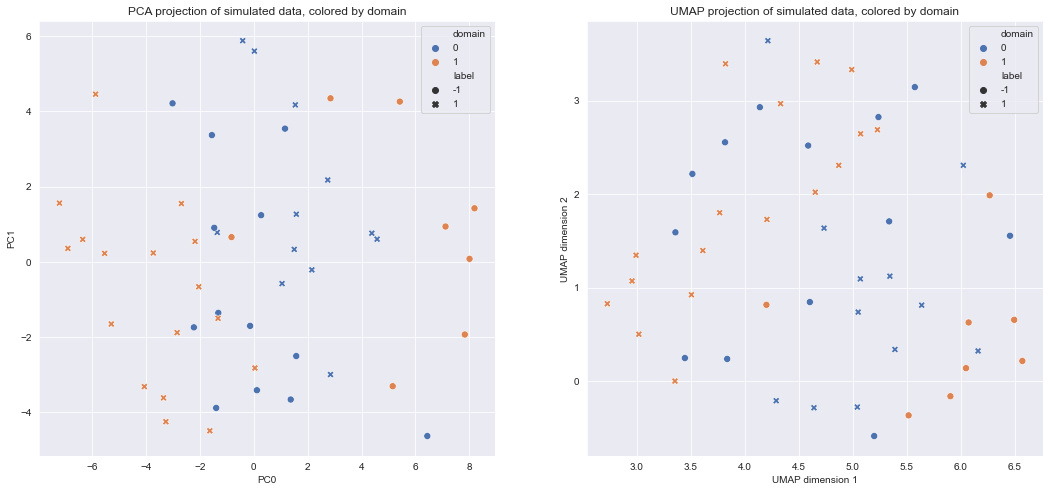

In [7]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

In [8]:
# split dataset into train/test
n_splits = 4
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs)):
    X_train, X_test = xs[train_ix, :], xs[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

,model,fold,metric,value
0,ridge,0,train_auroc,0.618421
1,random_forest,0,train_auroc,1.000000
2,ridge,1,train_auroc,0.677083
3,random_forest,1,train_auroc,1.000000
4,ridge,2,train_auroc,0.669565


(-0.1, 1.1)

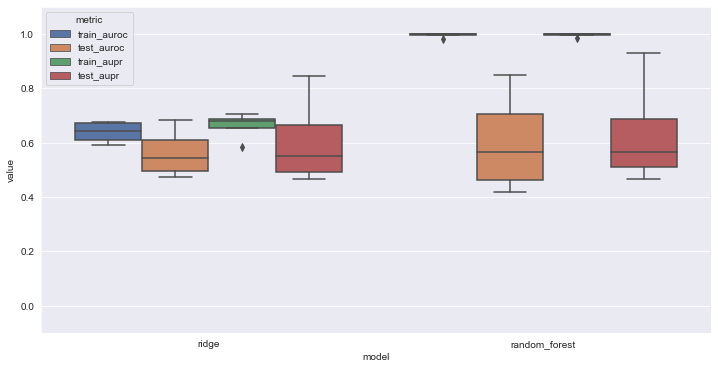

In [9]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)

In [10]:
xs_fixed = np.concatenate((xs, domains[:, np.newaxis]), axis=1)
print(xs_fixed[:5, :]) 

[[ 1.37549017 -2.15128522  2.02197102  0.18544308 -0.6867283  -2.23132893
   0.55074378 -1.69148401 -2.58301347 -0.90600931  0.        ]
 [-0.74003634  0.08240427 -0.11408596  2.9625803   1.31058028 -0.42946923
  -1.23289128  2.65982856  1.39819911  5.51179619  0.        ]
 [ 0.34407699  3.33445252  0.68314723 -0.38894781 -2.93369696  1.52921648
  -2.26832172 -1.30922792  0.08579154 -0.75037783  0.        ]
 [-2.94323849 -1.64217228  2.09965417  1.91632957  1.31066292  0.26099257
   1.9060509   0.76482143 -0.50927532  2.5293133   0.        ]
 [-0.30860028 -1.59024584  2.66283005  3.02778836 -3.23452818  1.18969433
  -3.50736417  2.42153888 -2.04039082  1.76819238  0.        ]]


In [11]:
# split dataset into train/test
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs_fixed)):
    X_train, X_test = xs_fixed[train_ix, :], xs_fixed[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

,model,fold,metric,value
0,ridge,0,train_auroc,0.618421
1,random_forest,0,train_auroc,1.000000
2,ridge,1,train_auroc,0.677083
3,random_forest,1,train_auroc,1.000000
4,ridge,2,train_auroc,0.669565


(-0.1, 1.1)

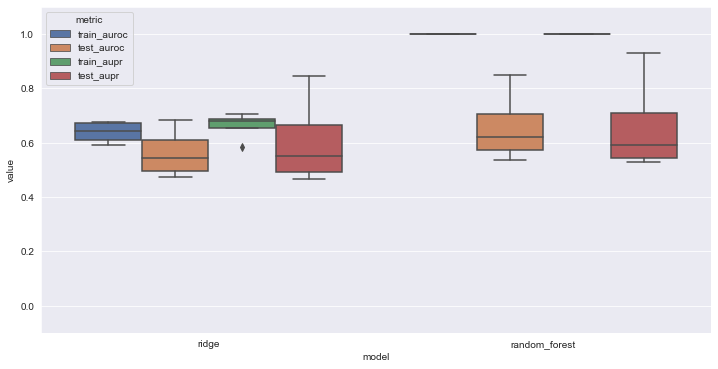

In [12]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)